In [3]:
import config
import load_data as ld
import array_analysis as aa
import numpy as np
import visualize as vis
from processing import processing
from time import time
import matplotlib.pyplot as plt

In [4]:
# load parameters
param = ld.get_parameters(config.folder_program, config.parameter_file)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lauma\\OneDrive\\Rümpker\\Salomonen\\KAVAPY/Streaming_Parameters/Test_case_gross2.txt'

In [3]:
 # loading data
[data, t, param] = ld.get_data(config.folder_data, config.freqmin, config.freqmax, param)

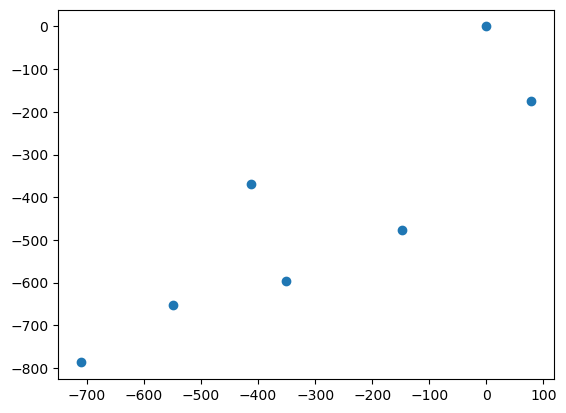

In [4]:
# Calculate distance matrices
dist_x, dist_y = aa.calc_dist(param["xm"], param["ym"], param["zm"])

In [5]:
# processing 
[median_c, max_d, rmse, v_app, BAZ] = processing(data, config.processing_window, dist_x, dist_y, config.corr_res, param["sr"])

In [6]:
BAZ_new = aa.rolling_stats(BAZ, aa.estimate_mode, window=config.mode_window) # rolling mode estimation
std = aa.rolling_stats(BAZ_new, aa.np.std, window=config.std_window) # rolling standard deviation
BAZ_new[std > config.std_threshold] = np.nan


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from load_data import generate_datetime_array, cut_data
import config
from array_analysis import pick_events
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def overview(data, t1, BAZ, rmse, corr, std, max_amp, sr):
    """
    Function, to visualize the final results of the processing

    Parameters
    ----------
    data : array
        Array, containing all traces
    t1 : array
        time array
    BAZ : array
        Array of backazimuth values
    rmse : array
        Array of root mean square errors
    corr : array
        Array of cross correlation data
    std : array
        Array of standard deviation
    max_amp : array
        array of maximum amplitude
    sr : float
        Sampling rate

    Returns
    -------
    None.

    """
    # Calculate sampling rate of backazimuth
    duration = config.duration_minutes*60
    sr2 = len(BAZ)/duration
    print(sr2)
    # Generate time array for backazimuth
    t2 = generate_datetime_array(config.date, config.year, int(24*60*60*sr2))
    [_, t2] = cut_data(data[:,0:len(t2)], t2, config.start_time, config.duration_minutes, sr2)
    # Choose trace to plot
    trace = data[1,:]
    # Start plotting
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8))
    # Plot trace
    plt.subplot(5,1,1)
    plt.plot(t1, trace, 'k')
    # Plot backazimuth
    plt.subplot(5,1,2)
    plt.scatter(t2, np.rad2deg(BAZ), 50, rmse)
    plt.ylabel("$\\beta [°]$")
    # Plot spans
    spans, modes = pick_events(BAZ)
    # Iterate over the span indices and plot the spans as shaded areas
    for i, (start, end) in enumerate(spans):
        if (end - start) > config.min_length:
            # Fill the area between -1 and 1 with color
            axes[1].fill_betweenx([-180,180], t2[start], t2[end], alpha=0.3, label='Span Area', color='gray')
            plt.text(t2[start],210,str(int(np.rad2deg(modes[i]))))
    # Plot Cross correlation
    plt.subplot(5,1,3)
    plt.plot(t2, corr, 'k')
    plt.ylabel("Cross Correlation")
    # Plot a horizontal line at y = 0
    axes[2].axhline(y=config.c_median_threshold, color='red', linestyle='--', label='Horizontal Line')
    # Plot standard deviation of the backazimuth values
    plt.subplot(5,1,4)
    plt.plot(t2, std, 'k')
    plt.ylabel("$\sigma$")
    # Plot a horizontal line at y = 0
    axes[3].axhline(y=config.std_threshold, color='red', linestyle='--', label='Horizontal Line')
    # Plot maximum amplitude
    plt.subplot(5,1,5)
    plt.plot(t2, max_amp,'k')
    plt.ylabel("Maximum amplitude")
    plt.xlabel("time")
    # Plot a horizontal line at y = 0
    axes[4].axhline(y=config.amp_threshold, color='red', linestyle='--', label='Horizontal Line')
    

    # Set layout
    fig.tight_layout()
    fig.align_ylabels()
    # Customize the x-axis date format
    date_format = mdates.DateFormatter('%H:%M:%S')  # Change the format as needed
    axes[4].xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45) 
    # Deactivate x-axis labels (hide them)
    axes[0].set_xticklabels([]) 
    axes[1].set_xticklabels([]) 
    axes[2].set_xticklabels([]) 
    axes[3].set_xticklabels([]) 

    plt.show()

def cut_data(d, t, start_time, duration, sr):
    time = datetime.strptime(start_time, "%H:%M:%S")
    seconds = int((time - datetime(1900, 1, 1)).total_seconds())
    start_index = int(seconds*sr)
    end_index = start_index + int(duration*60*sr)
    d_cut = d[:,start_index:end_index]
    t_cut = t[start_index:end_index]
    return d_cut, t_cut

4.835


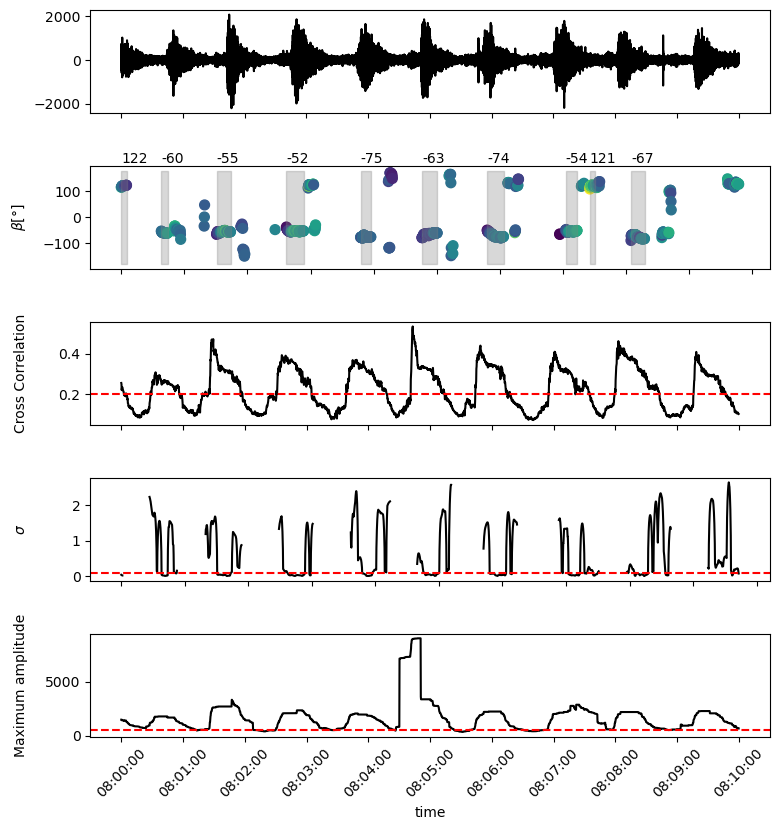

In [20]:
# Visualizing results
overview(data, t, BAZ_new, rmse, median_c, std, max_d, param["sr"])